# Analysis of NLI model confidence & sentence embedding enhancements

This is a reprodicibilty report of [_Supervised Learning of Universal Sentence Representations from Natural Language Inference Data_ by Conneau _et al._ (2017)](https://arxiv.org/abs/1705.02364), where we reproduce and analyze the main findings. Furthermore, we analyze why certain models perform better than others by looking at the distribution and confidence of the predictions. Finally, we explore how sentence embeddings can be enhanced by multiplying them with trainable weights.

In [1]:
%load_ext autoreload
%autoreload 2

# Import the plot classses that read all the results and plots them
import sys
sys.path.insert(0, 'nli/')
from plot import PlotResults, PlotResultsMult


[nltk_data] Downloading package punkt to /home/lcur1112/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
plots = PlotResults(
    models = ['avg_word_emb', 'uni_lstm', 'bi_lstm', 'max_pool_lstm'], # The models to plot
    versions = ['version_0', 'version_0', 'version_0', 'version_0'],   # The versions of the models, if a model is retrained, another version is created
    dims = [300, 2048, 4096, 4096],                                    # The dimension of the sentence embeddings of the models
)

## Reproducing Conneau _et al._ (2017)

We have implemented four models hat act as a sentence encoder. These models are trained and tested on the SNLI datasets. Afterwards, these trained encoders are used to produce universal sentence representations, as these sentence representations are used to train on a variety of transfer tasks with [_SentEval: An Evaluation Toolkit for Universal Sentence Representations_ by Conneau and Kiela (2018)](https://arxiv.org/abs/1803.05449). We have implemented four models: 

1. Average Word Embeddings (AvgWordEmb), acting as a baseline;
2. Unidirectional LSTM (UniLSTM) applied on the word embeddings, where the last hidden state is considered as the sentence representation;
3. Bidirectional LSTM (BiLSTM-last), where the last hidden state of the forward and backward layers are concatenated and considered as the sentence representation;
4. Bidirectional LSTM with max pooling (BiLSTM-Max), where the max-pooled hidden states of the forward and backward layers are concatenated and considered as the sentence representation.

A visualization of the models is shown in the figure below. The UniLSTM and BiLSTM-Max are the same as the implementations of Conneau _et al._ (2017), Sections 3.2.1 and 3.2.2, respectively. 


<div align="middle">
<img src="figs/models.png" width = 70%/>
</div>

**Figure 1:** Four models that are trained to produce universal sentence representations

### Design choices & Implementation

As we did our best to reproduce the impementation of Conneau _et al._ (2017), it is always hard to have the exact implementation. The main differences to our knowledge are the following. First, we did not implement gradient-clipping. This is not mentioned in the paper, but it is implemented in the [public available code](https://github.com/ihsgnef/InferSent-1). Furthermore, in the paper there are no further details reported on the classifier besides 'multiple fully-connected layers culminating in a softmax layer'. In the code they have classifiers with and without non-linearities. Because the default we set to no non-linearities, we stick to that too.

The GloVe word vectors are built into our models by initalizing a first layer, `nn.Embedding`, with these word vectors. We have the vocabulary aligned with the SNLI corpus, and not with a concatenation of some of the datasets used in SentEval. Becausee of this, the size of the embedding layer is the intersection between the vocabulary of GloVe and the SNLI corpus. In general there is a trade-off between these two choices. Aligning it with the SNLI corpus will result in higher NLI results than when aligning it with the SentEval corpus. Contrary, aligning it with the SNLI corpus will result in lower transfer results than when aligning it with the SentEval corpus. We have chosen to align it with the SNLI corpus because we want our NLI task to perform the most stable and accurate for our analysis on sentence embedding enhancement, which is discussed later. Addionaly, we reason that if NLI creates _universal_ sentence representations, it's more important to focus on the NLI task than rather on the transfer task. Aligning it on the SentEval corpus would also make it harder to present flexible universel sentence representations for a variety of tasks. Once you want to apply the trained encoder on a new task (appliciation), ideally you would have to retrain the encoder because the vocabulary has been aligned with the corpus of other (not necessarly tangentanial) tasks.

In [3]:
plots.print_results()

,dim,dev,test,micro,macro
AvgWordEmb,300,65.7,65.8,80.6,78.9
UniLSTM,2048,80.0,79.1,78.7,78.0
BiLSTM-last,4096,80.2,80.0,81.5,81.0
BiLSTM-Max,4096,83.9,83.6,83.2,82.6


**Table 1:** Performance of sentence encoder models on SNLI (dev and test columns) and aggregated transfer tasks from SentEval (micro and macro columns). For a detailed description of the reported accuracies, see Conneau _et al._ (2017).


### NLI results

The results are summarised in Table 1, shown above. These results can partly be compared to Table 3 of Conneau _et al._ (2017). We first discuss the NLI results, the dev and test column, secondly the transfer task results from SentEval, the micro and macro column.

All models have similar dev and test accuracies, indicating that the model has not overfit. We will mostly discuss the dev and test accuracies at the same time, and look more at differences between models.
- The AvgWordEmb, the baseline, performs much better than a random guess, which would be 33%, as there are three classes (entailment, neutral and contradiction). However, compared to all the other models it does perform quite poorly. This is not surprising, as the model itself has no trainable parameters, and solely relies on the embeddings of GloVe and the classifier.
- The UniLSTM performs similar results to the reported performance in Conneau _et al._ (2017), altough with a difference of only difference $\sim 1 - 2 $ percentage points. The UniLSTM has trainaible paremters, which clarifies why it performs so much better than the baseline. Furthermore, an LSTM is designed to process word embeddings, while the taking the average, what the baselines, is just a general statistical operation.
- The BiLSTM-last does not have a direct comparison to a model in Conneau _et al._ (2017). However, if we assume that a BiLSTM-last performance is in between that of a BiGRU-last and BiLSTM-Mean (which are implemented in Conneau _et al._ (2017)), we can make a comparison. We reason that one can make this comparison because both models contain one of the two key elements of the model (the architecture and how the sentence represententations are selected). Comparing to the results of Conneau _et al._ (2017), we see that our BiLSTM-last does indeed have a performance in between that of BiGRU-last and BiLSTM-Mean. <br>
Furthermore, we note that BiLSTM-last performs slightly better than the UniLSTM. This is not inline with Conneau _et al._ (2017), where the LSTM outperforms the BiGRU-last and BiLSTM-Mean. However, the difference is only small, which could be due to minor implementation differences or seed differences.
- The BiLSTM-Max performs, similar as in Conneau _et al._ (2017), the best. The differences with the results reported in Conneau _et al._ (2017) are a bit larger than for the other models, at the order of one percentage point. However, this difference is not large enough the be concerned, as these values could be because of different seeds or small implementation differences as discussed above. <br>
The BiLSTM-Max performs better than the models because of mainly two aspects. First, the BiLSTM-max is able to consider hidden-states accross all times (i.e. the words of the sentence), while the other LSTM models only consider the last and first hidden-state. By having acces to all hidden-states, the sentence representation can have a richer representation, and is less dependent on the ability of an LSTM-cell to properly pass the necessary information to the next (or previous) LSTM-cell. Secondly, the max-pooling allows the model to focus and the highest, and therefore, the most descriptive, word-level hidden states. By just taking the last and first hidden-states, you do not allow the model to consider other parts as well.

### SentEval transfer results
The transfer results show similar trends as in Conneau _et al._ (2017) (excluding the AvgWordEmb for now): The UniLSTM has the worst performance, followed by the BiLSTM-last (again assuming that it's between BiGRU-last and BiLSTM-Mean), and the BiLSTM-Max with the best performance. Furthermore, the micro average is $\sim 1 - 2 $ percentage points higher than the macro average. 

While these trends are the same as in Conneau _et al._ (2017), the accuracies are consistenly $\sim 1 - 2 $ percentapge points lower than compared to Conneau _et al._ (2017). While this falls well within the accepted range, the consistency indicates that this is due to something different than different seeds. We suspect the difference because of the alignment of the initialization and alignment of the vocabulary inside the model. As discussed in the earlier section 'Design choices & Implementation', we align the vocabulary of the model with the SNLI corpus, before training the encoder. Our vocabulary is therefore fixed, and can not be updated anymore based upon the transfer tasks corpora. However, looking at the implementation of Conneau _et al._ (2017), it looks like their vocabulary is not fixed, and able to be re-algined before training a transfer task. More specifically, this happens in [this line of code](https://github.com/facebookresearch/SentEval/blob/5d6dc117d1ac30357ddaeb7347fb5684e9b87015/examples/infersent.py#L38). The fact that Conneau _et al._ (2017) rebuilds the vocabulary per transfer-task, while in our implementation the vocabulary is fixed to that of the SNLI corpus, can be the reason why the accuracies are consistenly $\sim 1 - 2 $ percentapge points lower.

Table 1 also shows that similar results on the NLI task does not necessarily translate to similar performance on the transfer tasks, when comparing UniLSTM and BiLSTM-Max. Conneau _et al._ (2017) hypothesizes that some models are likely to over-specialize and adapt too good on the SNLI dataset without capturing general sentence-information. Our results are in line with this hypothesis.

Although we just stated that NLI performance does not necessarily translate to transfer task performance, the AvgWordEmb performs surprisingly well on the transfer task based upon the NLI results. This indicates that there is something that that makes the transfer tasks relative easy for the AvgWordEmb compared to the other models. One reason could be that smaller sentence representation  sizes are better to handle by the transfer task in contrast to larger representations, as the AvgWordEmb produces representations with a length of 300, contrary to the 2048 or 4096-sized representations of the LSTM-variations. However, Figure 5 if Conneau _et al._ (2017) makes this hypothesis unlikely, as there is shown that, in general, micro averages are increasing with emebedding size. 

What could be an explanation of the fact that AvgWordEmb performs so well on the transfer task, is the data that makes up the transfer tasks. In Table 2, we show 10 samples of examples that make up the training data of the transfer task. We see that in four out of the eight tasks (MR, CR, MPQA, SST2), the examples are not full sentences, but one or two-worded phrases. TREC also consists of really short questions which conists of just a few words. It could very much the case that these short phrases do not have to be encoded by a universal sentence representation, i.e. the LSTM-variants, because they are not real sentences. If you are encoding such a one or two-worded phrase as it is a sentence, the encoder might represent it in an undesirable way, as the encoder is trained on complete sentences (the SNLI corpus). We leave a further analysis of this hypothesis for future work.


| Transfer task | Examples |
| ------------- | -------- |
| MR | obvious ; horrible ; crummy ; execrable . ; shallow . ; eh . ; abysmally pathetic ; terrible . ; wishy-washy . ; spiderman rocks |
| CR | * ; good looks ; enjoy . ; flawless . ; - speakerphone ; crappy headphones . |
| MPQA | complaining ; warned ; threaten ; accusing ; negatively ; biased ; claims |
| SUBJ | skip work to see it at the first opportunity . ; automatically pegs itself for the straight-to-video sci-fi rental shelf . ; a thoroughly unoriginal , but fast-paced and entertaining genre b-flick ; it looks good , but it is essentially empty . ; plays less like a coming-of-age romance than an infomercial . ; a remarkable 179-minute meditation on the nature of revolution . ; martyr gets royally screwed and comes back for more . ; desta vez , columbus capturou o pomo de ouro . ; an odd , haphazard , and inconsequential romantic comedy . ; just as moving , uplifting and funny as ever . |
| SST2 | disappointments ; hopeless ; collapse ; scant ; horrifying ; schticky ; ransacks ; underachiever ; devastatingly ; undramatic |
| TREC | Define cosmology . ; How was Lawrence ; Define Spumante . ; Who shoplifts ? ; What is BPH ? ; What is RCD ? ; What is HTML ? ; What is AFS ? ; What is DEET ? ; What is DTMF ? |
| MRPC | Moore had no immediate comment Tuesday . ; An Associated Press report is included . ; Every day more American soldiers die . ; ISC and NASCAR officials declined to comment . ; The Illinois Supreme Court dismissed the case . ; Mascia-Frye works in the state development office . ; Johnsons site is www.katyjohnson .com. Maxs is www.tuckermax.com. ; I loved the Brazilian music I played . ; America Online last quarter lost 846,000 dial-up subscribers . ; Only Intel Corp. has a lower dividend yield . |
| SICKEntailment | Someone is writing ; Someone is typing ; Some people are walking ; Some men are sawing ; The fish are immobile ; Some men are sawing ; A man is laughing ; A baby is laughing ; A baby is crying ; Some kittens are hungry |

**Table 2:** Examples of data of the transfer task, where different examples are seperated by a semicolumn.


# NLI demo

Below we present an interactive tool where we showcase what the confidences are on the Natural Language Inference task given any premise and hypothesis. You can write you own premise and hypotesis, two Beatles-inspired sentences are already given. Furthermore, you can select your favorite model type. The three colored bars indicate the prediction probability, i.e. the confidence, that the two sentences are an entailment, neutral or a contradiction with respect to eachother. During training and testing, the highest probability is chosen.

Loading model from logs/avg_word_emb/version_0/checkpoints!
Choosing baseline features!
Loading model from logs/avg_word_emb/version_0/checkpoints!
Choosing baseline features!


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lcur1112/.conda/envs/nli2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

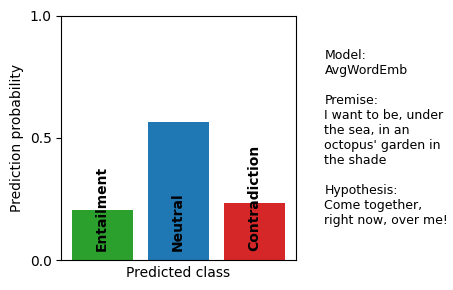

In [4]:
premise     =  "I want to be, under the sea, in an octopus' garden in the shade"
hypothesis  =  "Come together, right now, over me!"
model_type  = 'avg_word_emb' # Choose from ['avg_word_emb', 'uni_lstm', 'bi_lstm', 'max_pool_lstm']

plots.plot_new_sample(premise, hypothesis, model_type)

**Figure 2:** Prediction probability for a given premise and hypothesis.

# Analysis

Below, we analyze and compare the models in more detail. These analyses will give more insight why and where certain models fail, and how model A performs bettern than model B.

## Where do models fail?

Below in Figure 3, we show the same plot as disussed in Figure 2, but now static for all models and four fixed premise-hypothesis combinations. The arrows indicate the true class of the example.

In the first two examples _Two men sitting in the sun; Nobody is sitting in the shade_ and _A man is walking the dog; No cat is outside_, the model predicts contradiction very condfident, while the true class is neutral. The AvgWordEmb does give the more probility to neutral, but that is because this model is less confident overall - something which will be discussed shortly. A possible explanation why all models fail is because the word-combinations _sun; shade_ and _dog; cat_ are related, in the GloVe vector representation they would have a relative short distance to eachother. However, the model does learn correctly that _Two men sitting in X; Nobody is sitting in X_ and _A man is walking Y; no Y is outside_ are both contradictions. Because these _X/Y_-masked sentences are contradictions and the models thinks that what is put on the masks is related, the model predicts understable that these models are contracitions.

The third example, _We are enjoying this a lot; You and I are having fun together_ highlights the strentgh of the BiLSTM models, where they correctly very confident predict that the premise and hypothesis are entailment. The two other models are doubting between entailment and neutral, altough the UniLSTM would predict the correct class. The models have to understand that _We; You and I_ and _enjoying this a lot; having fun together_ are similar in this context. It seems to be that the BiLSTM models are able to pick up this information from the data, while the other models are not. Contrary, the fourth example shows that the BiLSTM-Max does not always outperforms the other models. With _I think that reading is bring; I do not like to consume books_, the BiLSTM-Max picks something up that is not there.

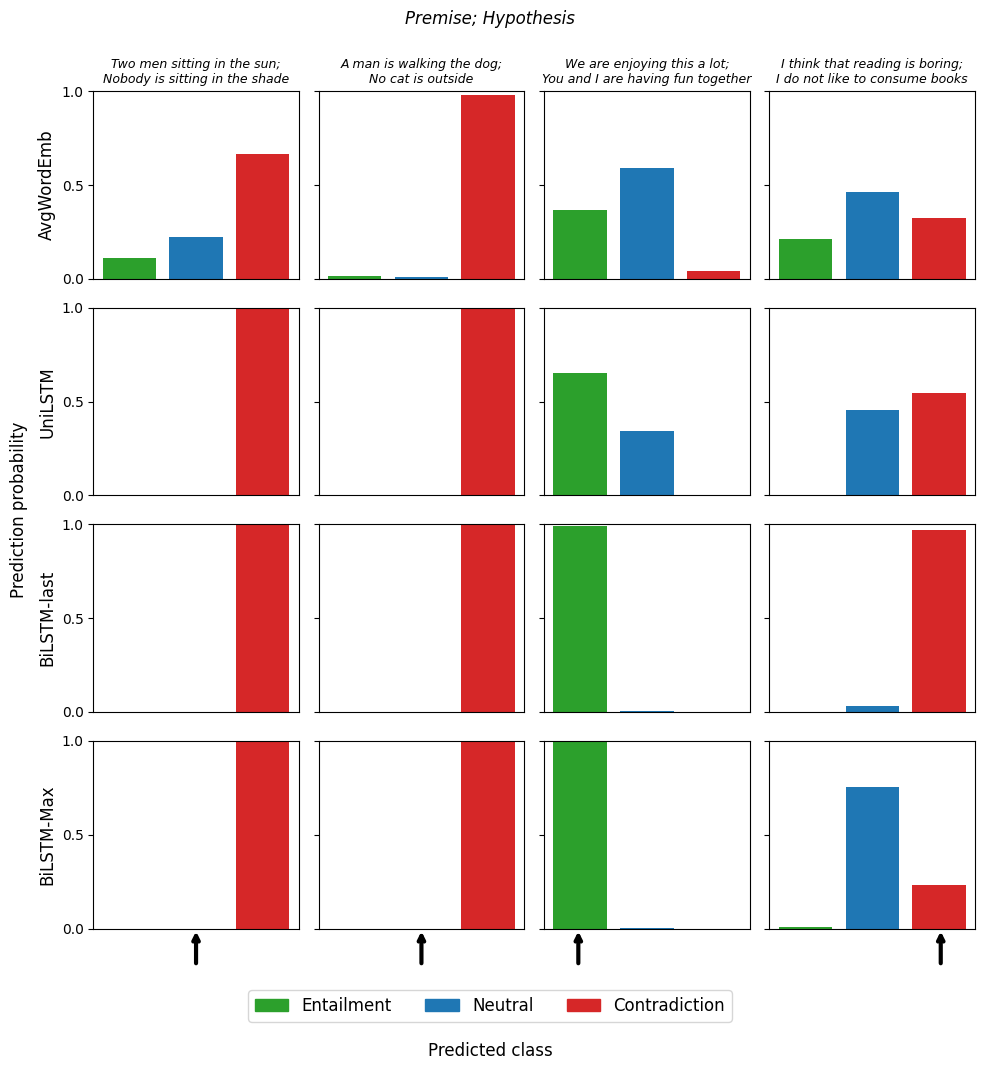

In [5]:
plots.plot_examples()

**Figure 3:** Prediction probability for a given premise-hypothesis combination. The arrow indicates the correct class.

As we saw before, AvgWordEmb performs the worst, while BiLSTM-Max performs the best. Where do the incorrect predictions go to? Do the incorrect predictions go the the same class for all models? We quantify this below.

In Figure 4 we show the normalized total number of predictions per class, where we group the predictions per true class. The rows indicate the different models, the columns indidicate what the true class should have been. That means that for a perfect prediction, the entailment bar should reach 1 in the entailment column, likewise for the neutral and contradiction. Note that the bars do not represent the same as in Figure 3. Before, in Figure 3, we were discussing _prediction probabilities_. Now, we are discussing _predictions_, which are the argmax over the prediction probability. Finally, the true classes are almost evenly distributed in the test class: $(3368, 3218, 3237)$ for entailment, neutral and contradiction, respectively.

We see a the same general trend across all models: If a model should have predicted $\ldots$
- $\ldots$ entailment but it wrong, it predicts neutral more often than contradiction.
- $\ldots$ neutral but is wrong, it is split between entailment and contractidiction (with a slight favour for entailment in the case of the LSTM-variants).
- $\ldots$ contradiction but it is wrong, it predicts neutral more often than entailment.

These trends make sense, as entailment and contradiction are further away from eachother than neutral is to any of them.


<!-- 
## How confident are models

Before, we saw how AvgWordEmb gives a higher probability for all classes for certain sentences. Below, we quantify this for all sentences of the test set for all models. In Figure 4 we show the normalized total number of predictions per class, where we group the predictions per true class. The rows indicate the different models, the columns indidicate what the true class should have been. That means that for a perfect prediction, the entailment bar should reach 1 in the entailment column, likewise for the neutral and contradiction. The true classes are almost evenly distributed in the test class: $(3368, 3218, 3237)$ for entailment, neutral and contradiction, respectively.

We can indeed confirm that the AvgWordEmb is less confident across
 -->


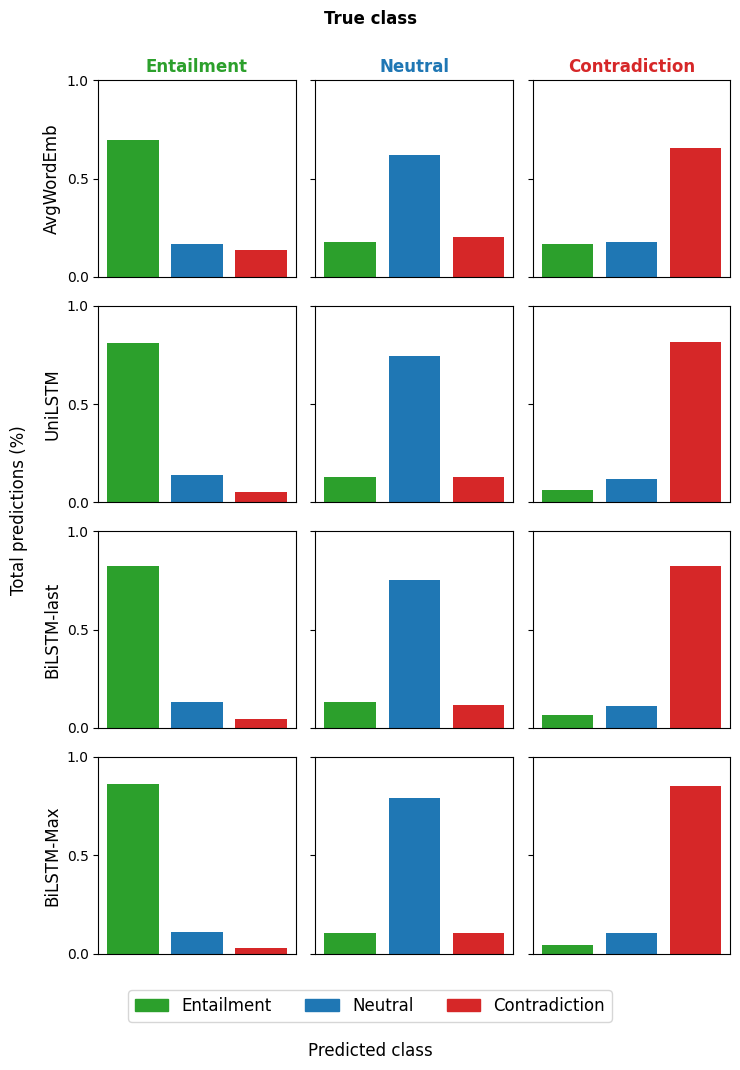

In [6]:
plots.plot_bars()

**Figure 4:** Predictions of the test set, grouped by true class (columns) and models (rows). See main text for discussion

## How confident are models

Before, we saw how AvgWordEmb gives a higher probability for all classes for certain sentences. Below, we quantify this for all sentences of the test set for all models. 

In Figure 5 we show a similar plot as Figure 4, but we are now going back to prediction probabilities again. The width of the violin indicates how often that class has been predicted. The mass of the violin is therefore related to the height of the bars in Figure 4. Hence, we can see the same trends as we have dicussed before. We can furthermore see some other interesting trends:
- AvgWordEmb is rarely very confident, even if it predicts has a correct prediction. This explains why it looks like AvgWordEmb is thinking in the right direction in the first example of Figure 3, but in reality it was just less confident overall. 
- The LSTM-variants, and especcialy the BiLSTM-Max, is always very confident (and most of the time correct). While doing this, it gives the other class correctly a very low probability.

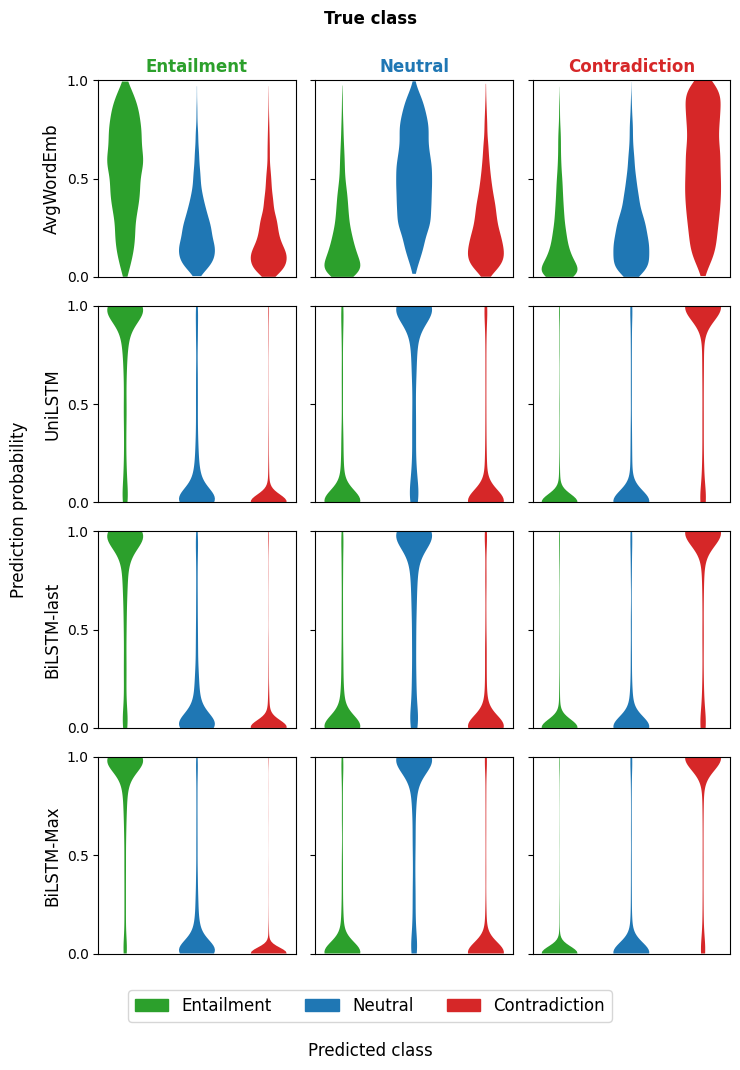

In [7]:
plots.plot_violin()

**Figure 5:** Violin plots of the prediction probability. Columns indicate true classes, rows indicate mode types.

## Sentence representations

To have a better undestanding of the what the sentence embeddings represent, we plot them in Figure 6. No direct useuful information can be taken away from this figure, but it helps us to understand what these embeddings represent. There are certain peaks in the embedding, but they are there typically for all the sentences. 

Scince the embeddings are trained to recognize entailment relationsships between premise and hypothesis, the embeddings are likely to capture syntactic and semantic relationships between the words, as well as information related to the meaning of the individual words in the sentences. However, the information stored in these emebddings is also limited because of its fixed length. For instance, the embeddings may not capture all of the nuances of meaning that can be conveyed through word choice, syntax, and context. Additionally, the embeddings may not be able to represent aspects of meaning that are specific to individual sentences or contexts, such as idiomatic expressions or cultural references. Finally, since the embeddings are learned in a supervised manner, they may not be able to capture all of the possible semantic relationships that can arise between sentences, but only those that are represented in the training data. All of this information can be lost when translating a sentence to an embedding.

<div align="middle">
<img src="figs/embs.png" width = 70%/>
</div>



In [9]:
# Commented out as the data necessary for this would take a lot of space, the figure is shown above. Plot can be calcualted if for all models nli/results.py is run.
# plots.plot_embeddings() 

**Figure 6:** Sentence embeddings from both the premise and hypothesis of the test set. The value indicates the mean, the shaded area indicates the standard deviation.

## Enhancing the sentence embeddings

In the original model, the sentence representations are concatenated as
$$
\text{features} = \text{concat}([u, v, u \odot v, \mid u - v \mid])
$$
where $u$ and $v$ are the sentence representations of the premise and hypothesis, respectively, $\odot$ is the element-wise product, and $\mid \cdot \mid$ is the absolute value. These features are then passed through the MLP. The multiplication and substraction operations are used to built inductive biases into the model. The multiplication operation captures the similarity between the two sentences, while the substraction operation captures the difference between the two sentences. Besides this reasoning, there is not a well-founded theoretical reason to use these features in the concatenation.

[_Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks_ by Reimers & Guryvuch (2019)](https://arxiv.org/abs/1908.10084) did an ablation study where they found the general trend that including more featues, such as $u \odot v$ and  $\mid u - v \mid$ to the concatenation resulted in higher performance of NLI. In their case, the concatenation $\text{concat}([u, v, \mid u - v \mid])$ had better performance than $\text{concat}([u, v, u \odot v, \mid u - v \mid])$. However, we will continue by including $u \odot v$, as the general trend is that keeping more features increases performance. The difference in accuracies by in/excluding $u \odot v$ is small in the paper, and their implementation is different as they are using a BERT-based model as an encoder.

We will _enhance_ the sentence embeddings by multiplying them with a trainable parameter $w_i$:
$$
\text{features} = \text{concat}([u, v, u \odot v, \mid u - v \mid] \cdot [w_1, w_2, w_3, w_4]^T)
$$
where $w_i$ are the trainable parameters. We initalize them to 1 such that the features start the same as the 'unenhanced' feature, i.e. features withouth trainable parameters. We hypothesize that these trainable parameters can improve performance because they give some kind of 'sentence-discriminative' embedding, and the inductive bias is more flexible. We discuss these two aspects below.

During the concatenation of unenhanced features, the information that the vectors $u$, $v$ $u \odot v$ and $\mid u - v \mid$ are different vectors, but have the same internal order, is lost. The classifier is probably able to learn this, but training time can decreased and performance might be increased when this information is given the the classifier. By multiplying the vectors with a different numbers ($w_i \neq w_j$ after the first iteration), it will be easier for the classifier to learn that the vectors are different but have the same internal order. Therefore, enhancing the sentence embeddings results in a 'sentence-discriminative' inductive-bias for the classifier.

The inductive bias that the mulitplication captures similarities and subtraction captures differences between the sentence embeddings might not be the optimal inductive bias. For instance, it might be that the similarities have to be magnified to be for any use of the classifier, i.e. $w_3 > 1$ in $(u \odot v) \cdot {w_3}$. Similarly, it could be the case that the premise is more important and useful for the classifier to perform well compared to the hypothesis, i.e. $w_1 > w_2$ in $(u\cdot{w_1}, v\cdot{w_2})$. By letting $w_i$ vary, the network can learn more directly what is more useful and less useful. Therefore, enhancing the sentence embeddings results in a flexible inductive bias.

In line with the inductive bias description above, we also experimented with exponents instead of multiplication, i.e. $u^{w_1}$ instead of $u\cdot{w_1}$. However, this resulted in NaN values due to unstable gradients.

In [10]:
plots = PlotResultsMult(
    models = ['avg_word_emb', 'uni_lstm', 'bi_lstm', 'max_pool_lstm'], # The models to plot
    features_types = ['baseline', 'multiplication'],
    versions = ['version_0', 'version_0', 'version_0', 'version_0'],   # The versions of the models, if a model is retrained, another version is created
)

Below, we show the same test and dev accuracies as presented in Table 1, but also include the enhanced sentence embedding results, indicated as a '(mult)' column. Falsifying our hypothesis, we observe that the accuracies are not considerable different between the baseline and multiplicated features. The differences are likely to due different seeds. This indicates that the original classifier is flexible enough to learn all the information captured in the sentence embeddings, and a 'sentence-discriminative' and/or more flexible inductive-bias is not needed. We do not show training times here, but training times are also not considerable different.

In [11]:
plots.print_results()

,dev,dev (mult),test,test (mult)
AvgWordEmb,65.7,65.7,65.8,66.1
UniLSTM,80.0,78.9,79.1,78.9
BiLSTM-last,80.2,79.5,80.0,79.7
BiLSTM-Max,83.9,83.2,83.6,83.3


**Table 3:** Dev and test results for the original features (as presented in Table 1) and the enhanced (multiplier) features. There is no considerable difference between the two implementations' performances.

More interesting is to see how the multipliers vary and converge during training, and how they vary across models. In most models, multiplication and difference features have high multiplier values, indicating that these are of most use for the classifier. We furthermore show $u/v$ which is not a feature during training, but the ratio between the $u$ and $v$ features. In all LSTM-variants, this ratio converges to a value higher than 1, indicating that the premise ($u$) is more important then the hypothesis $(v)$ for the classifier.

100%|██████████| 4/4 [00:00<00:00, 31.50it/s]


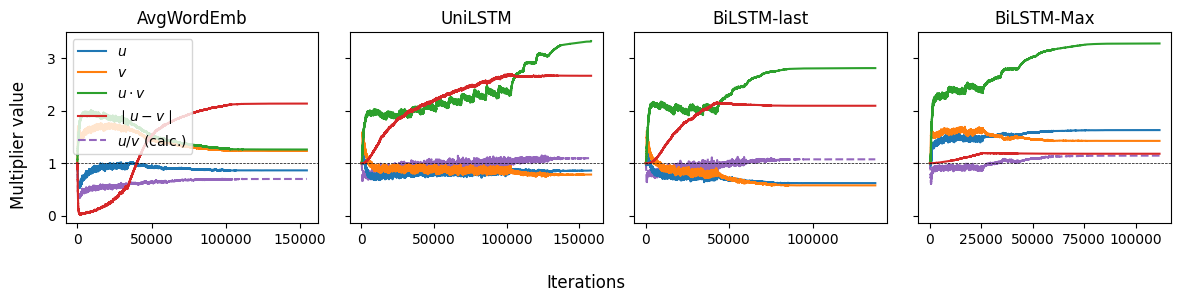

In [13]:
plots.plot_multipliers(calculate = True) # Calculate reads the Tensorbaord events to get the values during training. Can be turned off after they have been calculated once.

**Figure 7:** Multiplier values during training. Note that the legend refers the related multiplier, e.g. in the case of $u$ the blue line shows the value $w_1$ in $u \cdot w_1$.

For future work it would be interesting to more detailed ablation studies, similar to the Figure 7 shown above. Furthermore, more and other feature combinations can be added to the concatenation such as the cosine-similarity.